In [2]:
import numpy as np
from numpy import pi
from numpy.linalg import norm
from matplotlib import pyplot as plt
from scipy import signal
from scipy.ndimage import gaussian_filter

import simulation
import algorithm

## 仿真


### 声场仿真


设置参数


In [3]:
c = 1500
f = 37500
K = 1
d = 0.015
r = 100
theta = 80 / 180 * pi

fs = 1000000  # 采样频率1M
T = 1  # 采样时长

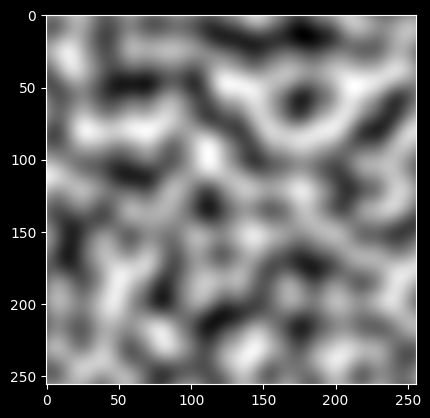

In [4]:
np.random.seed(0)  # 确保每次随机种子一样
noise_template = simulation.generate_perlin_noise_2d((256, 256), (8, 8))
noise_template = np.interp(noise_template, [np.min(noise_template), np.max(noise_template)], [-1, 1])
plt.imshow(noise_template, cmap='gray', interpolation='lanczos')
plt.show()

In [5]:
noise = noise_template.flatten()
noise = np.tile(noise, 1 + T * fs // (len(noise)))[:int(T * fs)]

In [6]:
d1, d2, d3 = (K + 1) * d / 2, (K - 1) * d / 2, (K + 1) * d / 2
S = np.array([r * np.cos(theta), r * np.sin(theta)])

r1 = float(norm(S - [-d1, 0]))
r2 = float(norm(S - [-d2, 0]))
r3 = float(norm(S - [d3, 0]))

# 真实时延
t12 = (r1 - r2) / c
t23 = (r2 - r3) / c

# 三阵元处采样信号序列
s1 = simulation.sig_gen(c, f, r1, fs, T)
s2 = simulation.sig_gen(c, f, r2, fs, T)
s3 = simulation.sig_gen(c, f, r3, fs, T)

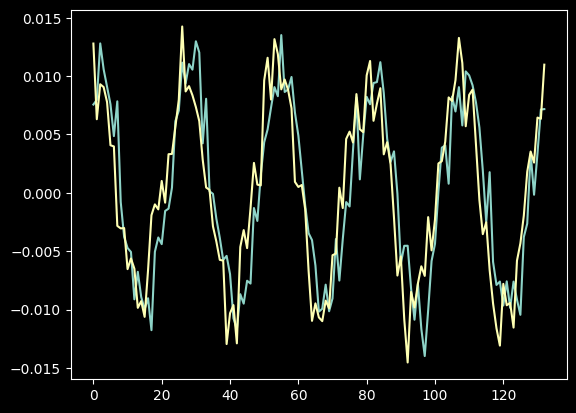

In [7]:
plt.plot(s1[:5*fs//f])
plt.plot(s2[:5*fs//f])
plt.show()

In [8]:
s1 = gaussian_filter(s1, sigma=5)
s2 = gaussian_filter(s2, sigma=5)
corr12 = signal.correlate(s1, s2)
corr12 = corr12 / np.max(corr12)
lags12 = signal.correlation_lags(len(s1), len(s2))
lag12 = lags12[np.argmax(corr12)] / fs

corr13 = signal.correlate(s2, s3)
corr13 = corr13 / np.max(corr13)
lags23 = signal.correlation_lags(len(s2), len(s3))
lag23 = lags23[np.argmax(corr13)] / fs
print(f'真实时延tau12: {t12}\n估计时延lag12: {lag12}\n差异: {np.abs(t12 - lag12) / t12 * 100:.2f}%')
print(f'真实时延tau23: {t23}\n估计时延lag23: {lag23}\n差异: {np.abs(t23 - lag23) / t23 * 100:.2f}%')

真实时延tau12: 1.737209142457156e-06
估计时延lag12: -2.5e-05
差异: 1539.09%
真实时延tau23: 1.7357543729967043e-06
估计时延lag23: -2.5e-05
差异: 1540.30%


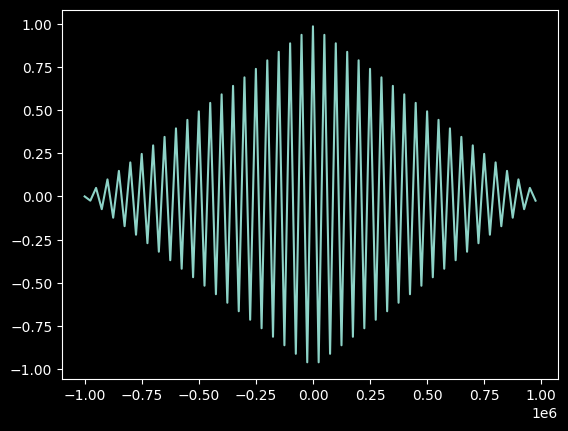

In [9]:
scale = 40
plt.plot(lags12[::fs//scale], corr12[::fs//scale])
plt.show()

In [10]:
r_e, theta_e = algorithm.far_locate(lag12, lag23, c, K, d)
# 可视化
print(f'真实: ({r}, {theta/pi*180})\n估计: ({r_e}, {theta_e/pi*180})')
print(algorithm.far_locate(t12, t23, c, K, d))

真实: (100, 80.0)
估计: (nan, nan)
(100.00000042100294, 1.3962634035189225)


/home/leo/Desktop/ternary-array-passive-bearing/algorithm.py:22: RuntimeWarning: invalid value encountered in arccos
  theta_e = np.arccos((c * t13_e) / ((K + 1) * d))
